<a href="https://colab.research.google.com/github/schizohub/PyTorch_lessons/blob/main/classification_withNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [152]:
n_samples = 10000

X, y = make_moons(
    n_samples,
    noise=0.03,
    random_state=42
)

In [153]:
X[:10], y[:10]

(array([[ 0.3423736 , -0.18332506],
        [-0.89759408,  0.15006114],
        [ 0.44922107,  0.8573337 ],
        [-0.95010451,  0.15419239],
        [-0.9495338 ,  0.31490938],
        [ 0.29047011, -0.26469378],
        [ 0.96511409,  0.3376876 ],
        [-0.04336249,  0.34632707],
        [ 0.33637853, -0.25059709],
        [ 0.96005955,  0.25397398]]), array([1, 0, 0, 0, 0, 1, 0, 1, 1, 0]))

In [5]:
import requests 
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("No need to download, skipping it...")
else:
    print("Download 'em")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)
from helper_functions import plot_predictions, plot_decision_boundary

No need to download, skipping it...


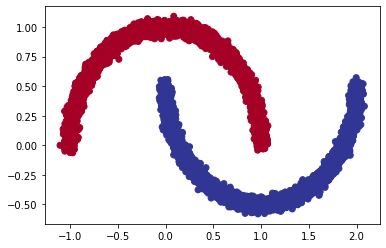

In [154]:
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu);

In [155]:
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

X[:10], y[:10]

(tensor([[ 0.3424, -0.1833],
         [-0.8976,  0.1501],
         [ 0.4492,  0.8573],
         [-0.9501,  0.1542],
         [-0.9495,  0.3149],
         [ 0.2905, -0.2647],
         [ 0.9651,  0.3377],
         [-0.0434,  0.3463],
         [ 0.3364, -0.2506],
         [ 0.9601,  0.2540]]),
 tensor([1., 0., 0., 0., 0., 1., 0., 1., 1., 0.]))

In [156]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([8000, 2]),
 torch.Size([2000, 2]),
 torch.Size([8000]),
 torch.Size([2000]))

In [157]:
class NNLinearClassifier(nn.Module):
    def __init__(self, input_features, hidden_units, output_features):
        super().__init__()

        self.layer_1 = nn.Linear(in_features=input_features,
                                 out_features=hidden_units)
        self.layer_2 = nn.Linear(in_features=hidden_units,
                                 out_features=hidden_units)
        self.layer_3 = nn.Linear(in_features=hidden_units,
                                 out_features=output_features)
    
    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))


def accuracy_fn(y_true, y_preds):
    correct = torch.eq(y_true, y_preds).sum().item()
    acc = (correct/len(y_preds))*100
    return acc

In [158]:
model_1 = NNLinearClassifier(input_features=2,
                             hidden_units=10,
                             output_features=1).to(device)

model_1

NNLinearClassifier(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [159]:
loss_fn_1 = nn.BCEWithLogitsLoss()
optim_1 = torch.optim.SGD(params=model_1.parameters(), lr=0.3)
type(loss_fn_1)

torch.nn.modules.loss.BCEWithLogitsLoss

In [160]:
def Fine_tune(model:torch.nn.Module,
              optimizer,
              loss_fn:torch.nn.Module,
              X,y,
              X_test,y_test, epochs=100, device:torch.device=device):
    
    for epoch in range(epochs):
        model.train()

        X,y = X.to(device), y.to(device)

        y_logits = model(X).squeeze()

        y_pred = torch.round(torch.sigmoid(y_logits))

        loss = loss_fn(y_logits,
                       y)
        
        acc = accuracy_fn(y, y_pred)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        model.eval()

        with torch.inference_mode():
            X_test, y_test = X_test.to(device), y_test.to(device)

            test_logits = model(X_test).squeeze()

            test_pred = torch.round(torch.sigmoid(test_logits))

            test_loss = loss_fn(test_logits,
                                y_test) 
            
            test_acc = accuracy_fn(y_test, test_pred) 
        
        if epoch%10==0:
            print(f"Epoch: {epoch}| Train loss: {loss:.4f}, Train acc: {acc:.2f}%| Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%")


In [162]:
Fine_tune(model_1, optim_1, loss_fn_1, X_train, y_train, X_test, y_test)

Epoch: 0| Train loss: 0.2423, Train acc: 88.84%| Test loss: 0.2121, Test acc: 90.50%
Epoch: 10| Train loss: 0.2423, Train acc: 88.89%| Test loss: 0.2119, Test acc: 90.60%
Epoch: 20| Train loss: 0.2423, Train acc: 88.94%| Test loss: 0.2118, Test acc: 90.65%
Epoch: 30| Train loss: 0.2423, Train acc: 88.92%| Test loss: 0.2118, Test acc: 90.65%
Epoch: 40| Train loss: 0.2423, Train acc: 88.91%| Test loss: 0.2117, Test acc: 90.65%
Epoch: 50| Train loss: 0.2423, Train acc: 88.92%| Test loss: 0.2117, Test acc: 90.65%
Epoch: 60| Train loss: 0.2423, Train acc: 88.92%| Test loss: 0.2117, Test acc: 90.60%
Epoch: 70| Train loss: 0.2423, Train acc: 88.91%| Test loss: 0.2117, Test acc: 90.60%
Epoch: 80| Train loss: 0.2423, Train acc: 88.90%| Test loss: 0.2117, Test acc: 90.60%
Epoch: 90| Train loss: 0.2423, Train acc: 88.90%| Test loss: 0.2117, Test acc: 90.60%


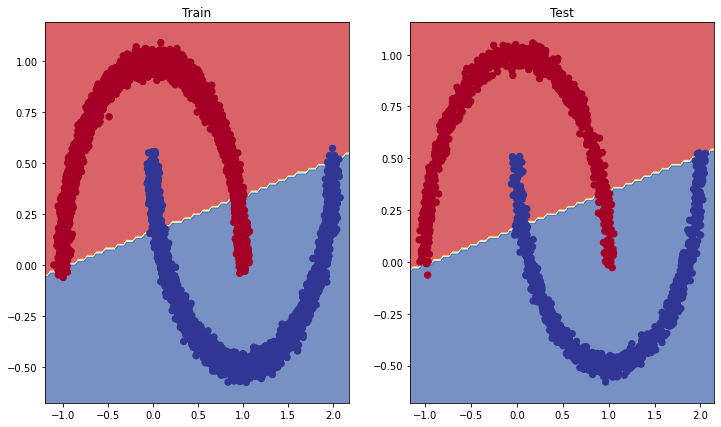

In [163]:
plt.figure(figsize=(12,7))
plt.subplot(1,2,1)
plot_decision_boundary(model_1, X_train, y_train) 
plt.title("Train")

plt.subplot(1,2,2)
plot_decision_boundary(model_1, X_test, y_test)
plt.title("Test");


In [15]:
# !pip install torchmetrics
# !pip install mlxtend -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
import mlxtend
mlxtend.__version__

'0.21.0'

In [51]:
from torchmetrics import ConfusionMatrix
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns
def Confusion_matrix(y_true, y_preds):
    confmat = ConfusionMatrix(task='binary', num_classes=2)
    confmat_tensor = confmat(y_preds, y_true)

    plt.figure(figsize=(10,7))
    sns.heatmap(confmat_tensor, annot=True,linewidths=1,linecolor='purple');
    print(metrics.classification_report(y_true, y_preds))

def Binary_curve(y_true, y_preds):
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_preds)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='ROC curve')
    display.plot()
    plt.show()

In [164]:
with torch.inference_mode():
    logits = model_1(X_test).squeeze()

    preds = torch.round(torch.sigmoid(logits))

              precision    recall  f1-score   support

         0.0       0.91      0.91      0.91      1009
         1.0       0.91      0.90      0.90       991

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000



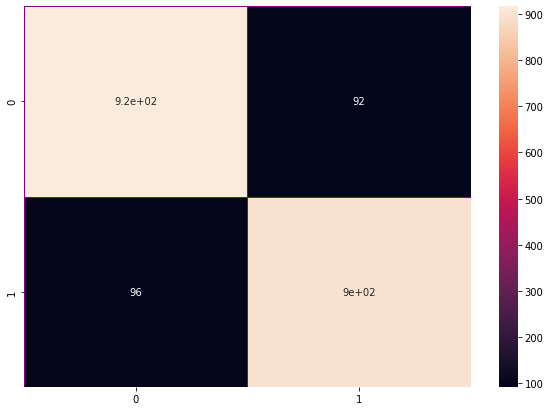

In [165]:
Confusion_matrix(preds, y_test)

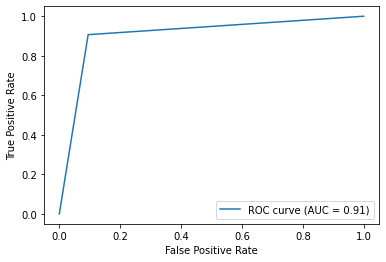

In [166]:
Binary_curve(y_test, preds)

In [196]:
class NNNonLinearClassifierV1(nn.Module):
    def __init__(self, input_features, hidden_units, output_features):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features,
                      out_features=hidden_units),
            # nn.ReLU6(),
            nn.Tanh(),
            nn.Linear(in_features=hidden_units,
                      out_features=hidden_units),
            # nn.ReLU6(),
            nn.Tanh(),
            nn.Linear(in_features=hidden_units,
                      out_features=output_features),
        )

    def forward(self, x):
        return self.layer_stack(x)



In [197]:
model_2 = NNNonLinearClassifierV1(input_features=2,
                                hidden_units=64,
                                output_features=1)

model_2

NNNonLinearClassifierV1(
  (layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [198]:
loss_fn_2 = nn.BCEWithLogitsLoss()
optim_2 = torch.optim.SGD(params=model_2.parameters(), lr=0.3)

In [201]:
Fine_tune(model_2, optim_2, loss_fn_2, X_train,y_train, X_test, y_test,)

Epoch: 0| Train loss: 0.0910, Train acc: 96.67%| Test loss: 0.0784, Test acc: 97.35%
Epoch: 10| Train loss: 0.0773, Train acc: 97.46%| Test loss: 0.0666, Test acc: 97.95%
Epoch: 20| Train loss: 0.0657, Train acc: 98.45%| Test loss: 0.0567, Test acc: 98.70%
Epoch: 30| Train loss: 0.0561, Train acc: 99.15%| Test loss: 0.0485, Test acc: 99.35%
Epoch: 40| Train loss: 0.0483, Train acc: 99.59%| Test loss: 0.0418, Test acc: 99.65%
Epoch: 50| Train loss: 0.0419, Train acc: 99.81%| Test loss: 0.0363, Test acc: 99.90%
Epoch: 60| Train loss: 0.0366, Train acc: 99.88%| Test loss: 0.0318, Test acc: 99.95%
Epoch: 70| Train loss: 0.0323, Train acc: 99.95%| Test loss: 0.0281, Test acc: 99.95%
Epoch: 80| Train loss: 0.0288, Train acc: 99.99%| Test loss: 0.0250, Test acc: 100.00%
Epoch: 90| Train loss: 0.0258, Train acc: 100.00%| Test loss: 0.0224, Test acc: 100.00%


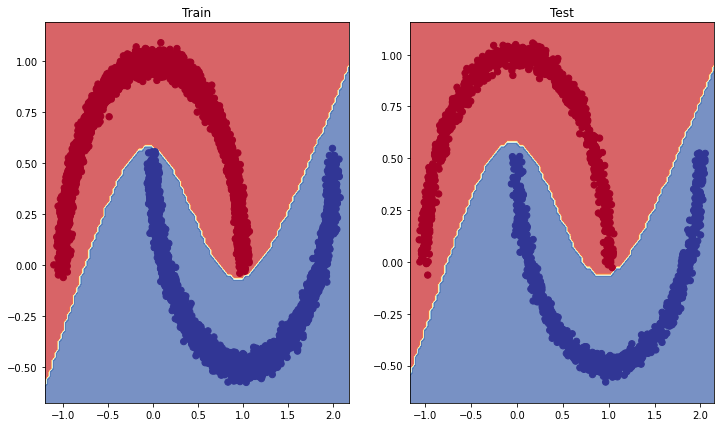

In [202]:
plt.figure(figsize=(12,7))
plt.subplot(1,2,1)
plot_decision_boundary(model_2, X_train, y_train) 
plt.title("Train")

plt.subplot(1,2,2)
plot_decision_boundary(model_2, X_test, y_test)
plt.title("Test");

In [203]:
with torch.inference_mode():
    logits = model_2(X_test).squeeze()

    preds = torch.round(torch.sigmoid(logits))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1013
         1.0       1.00      1.00      1.00       987

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



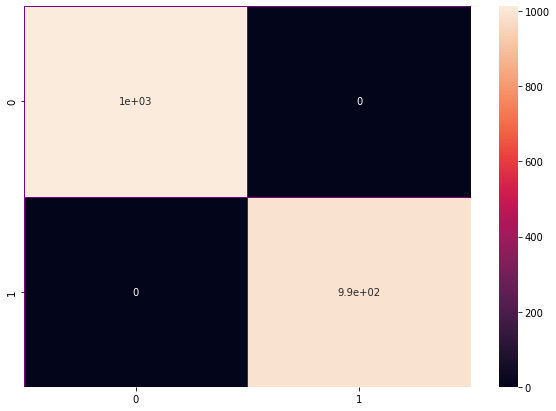

In [204]:
Confusion_matrix(y_true=y_test, y_preds=preds)

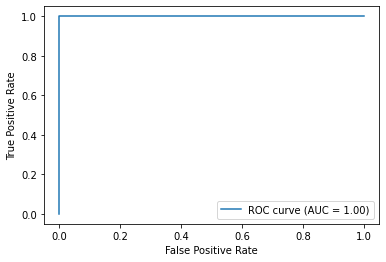

In [205]:
Binary_curve(y_test, preds)

In [206]:
class NNNonLinearClassifierV2(nn.Module):
    def __init__(self, input_features, hidden_units, output_features):
        super().__init__()

        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features,
                      out_features=hidden_units),
            nn.ReLU6(),
            nn.ReLU6(),
            nn.Linear(in_features=hidden_units,
                      out_features=hidden_units),
            nn.ReLU6(),
            nn.ReLU6(),
            nn.Linear(in_features=hidden_units,
                      out_features=output_features)
        )

    def forward(self, x):
        return self.layer_stack(x)

In [207]:
model_3 = NNNonLinearClassifierV2(input_features=2,
                                  hidden_units=64,
                                  output_features=1)

model_3

NNNonLinearClassifierV2(
  (layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU6()
    (2): ReLU6()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU6()
    (5): ReLU6()
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [208]:
loss_fn_3 = nn.BCEWithLogitsLoss()
optim_3 = torch.optim.Adam(params=model_3.parameters(), lr=0.3)

In [209]:
Fine_tune(model_3, optim_3, loss_fn_3, X_train, y_train, X_test, y_test)

Epoch: 0| Train loss: 0.6966, Train acc: 40.06%| Test loss: 4.2116, Test acc: 50.65%
Epoch: 10| Train loss: 0.4519, Train acc: 81.53%| Test loss: 0.2611, Test acc: 83.25%
Epoch: 20| Train loss: 0.1379, Train acc: 92.35%| Test loss: 0.1083, Test acc: 94.85%
Epoch: 30| Train loss: 0.0089, Train acc: 99.89%| Test loss: 0.0087, Test acc: 99.70%
Epoch: 40| Train loss: 0.0007, Train acc: 100.00%| Test loss: 0.0007, Test acc: 100.00%
Epoch: 50| Train loss: 0.0003, Train acc: 100.00%| Test loss: 0.0002, Test acc: 100.00%
Epoch: 60| Train loss: 0.0001, Train acc: 100.00%| Test loss: 0.0001, Test acc: 100.00%
Epoch: 70| Train loss: 0.0000, Train acc: 100.00%| Test loss: 0.0000, Test acc: 100.00%
Epoch: 80| Train loss: 0.0000, Train acc: 100.00%| Test loss: 0.0000, Test acc: 100.00%
Epoch: 90| Train loss: 0.0000, Train acc: 100.00%| Test loss: 0.0000, Test acc: 100.00%


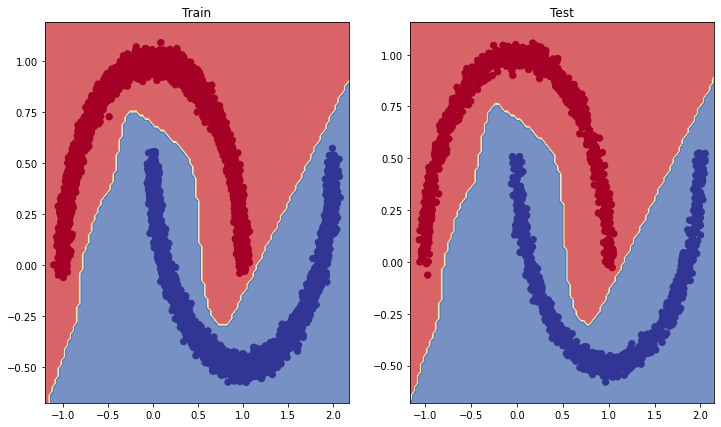

In [210]:
plt.figure(figsize=(12,7))
plt.subplot(1,2,1)
plot_decision_boundary(model_3, X_train, y_train) 
plt.title("Train")

plt.subplot(1,2,2)
plot_decision_boundary(model_3, X_test, y_test)
plt.title("Test");

In [212]:
with torch.inference_mode():
    logits = model_3(X_test).squeeze()

    preds = torch.round(torch.sigmoid(logits))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1013
         1.0       1.00      1.00      1.00       987

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



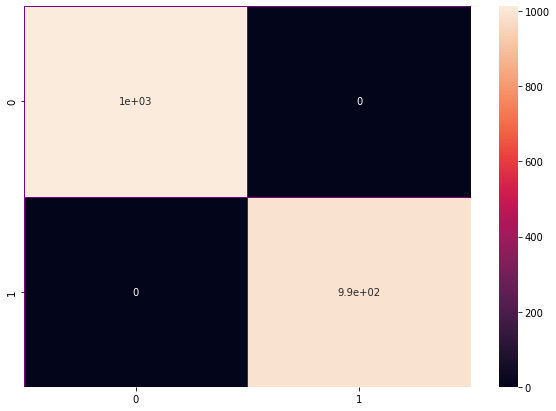

In [213]:
Confusion_matrix(y_test, preds)